# Acquiring, processing, and analyzing steady state yeast imaging data

## 1. Acquire data

1. Grow cells to mid-log phase in 3 ml of SC media
1. Centrifuge 2 ml of above culture at 10,000 RCF for two minutes
1. Remove about 1.9 ml of supernatant except for and vortex to resuspend cells in remaining ~50-100 &mu;l
1. Keep samples on ice until ready to image
1. Place 5 &mu;l of sample onto a coverslip and place another coverslip on top. Less volume means cells are less likely to keep sliding around while you're imaging
1. Place coverslip-sandwiched sample on stage and bring into perfect focus. For edge segmentation to work optimally, bring into focal plane where cell edges are bright and cell interior is dark.
1. Set multi-dimensional acquisition settings in &mu;manager:
    * Single timepoint
    * Multiple positions: set three positions that will be taken for each sample. Add more if you don't see at least 20 cells per position
    * Channels: Add channels you want to acquire. Include brightfield. 30-40 ms of exposure in each channel at full SOLA light source power will be plenty
    * Set directory root to a folder with a name describing the experiment, e.g. `20230510_transformants_05042023`
    * Set Name prefix to a filename with complete sample features. e.g. `20230510_hsp42del_pJC359_clone1`.
    * Set saving format to Separate image files
1. Click acquire
1. Switch out sample, bring into focus, update filename and click acquire again.

## 2. Create a master index and reformat data for segmentation

### Transfer the data to the machine on which the analysis will run

1. All imaging experiment folders (e.g. `20230510_transformants_05042023`) need to be kept in the directory defined at `byc.constants.steady_state_data_dir`. So open `byc/constants.py` and update the `steady_state_data_dir` variable. On my machine this is `C:/Users/johnp/Box/Finkelstein-Matouschek/images`
1. Move the imaging data into a directory called `data` within your experiment directory. The tree should look like:

```sh
cd C:\Users\johnp\Box\Finkelstein-Matouschek\images\20230510_transformants_05042023
tree .
C:\Users\johnp\Box\Finkelstein-Matouschek\images\20230510_transformants_05042023
└───data
    ├───20230510_hsp42del_pJC359_clone1_1
    │   ├───Pos0
    │   ├───Pos1
    │   └───Pos2
    ├───20230510_hsp42del_pJC359_clone2_1
    │   ├───Pos0
    │   ├───Pos1
    │   └───Pos2
    ├───20230510_hsp42del_pJC359_clone3_1
    │   ├───Pos0
    │   ├───Pos1
    │   └───Pos2
```

### Create the master index for the data set. 
This master index is created using features detected in sample names. If you want to add more information about each sample to the master index, you can open it and manually enter information. All information added to the master index will be added to the fluorescence data when it is read in after segmentation.

In [5]:
from byc import files

exptname = '20210909_Ub_Uba1_Rad6_OE_JPC121_pJC485_CMY3465'
mdf = files.make_ss_mdf(exptname)

### Rename the tif files with complete sample decsription
This is necessary to give the segmentation plugin the right formatting and it makes it easier to manually inspect the images

In [3]:
files.rename_steady_state(master_index_df=mdf)

## 3. Segment the data in Fiji

1. If not already done, install `imagejpc` [plugins](https://github.com/johnpcooper/imagejpc) according to the documentation in `BYC_pipeline.ipynb` [notebook](https://github.com/johnpcooper/byc/blob/master/notebooks/BYC_pipeline.ipynb)
1. Run the `measure_steady_state.py` plugin in Fiji by focusing the search bar ('l'), typing 'measure steady state', and pressing enter. The plugin will ask you how many channels were acquired. Type this number, e.g. '4' if BF, YFP, RFP, and GFP were acquired
1. This plugin will open all the channels for each sample, segment the brightfield data so that the max number of cells is found, then use those ROIs to measure fluorescence within each cell for each channel. Each set of measurements is saved as a .csv with the same name as the image on which it was measured. ROI sets are also saved as .roi files

## 4. Read in the quantified data and analyze
The `mdf_path` needs to be set manually to refer to the file created above with `mdf = files.make_ss_mdf(exptname)`

### Import packages, read in master index and data and use mdf to annotate data

In [9]:
# %%capture data_readin_output 
# Capture printed output so it take up a ton of space in rendered notebook
import glob, os

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
params = {'mathtext.default': 'regular',
          'font.sans-serif': 'Arial'}
plt.rcParams.update(params)

from byc import steady_state_analysis as ssa
from byc import plotting
# mdf_path needs to be reset manually
# Before reading in the master index, you can edit the .csv file at 
# the path below. For example, I've edited the file to have deletion
# written in the "strain" column
mdf_path = r"C:\Users\johnp\Box\Finkelstein-Matouschek\images\20210909_Ub_Uba1_Rad6_OE_JPC121_pJC485_CMY3465\20210909_master_index.csv"
mdf = pd.read_csv(mdf_path)
alldf = ssa.make_expt_df(mdf_path, bg_channel='yfp', filter_cells=False)
# Annotate sample name in a simple way
alldf.loc[:, 'sample_name'] = alldf.measdirname.apply(lambda x: os.path.basename(x))
# Annotate deletion with pretty formatting
# alldf.loc[:, 'background'] = alldf.strain.apply(lambda x: plotting.get_gene_deletion_string(x))
# Set values for background fluorescence. Typically this would be
# done using mean fluorescence in a strain expressing no constructs
# so that we can normalize to autofluorescence. Here I'm just using
# fluorescence from the media
bg_dict = {
    'yfp_mean': 116
}

for channel, bgval in bg_dict.items():
    alldf.loc[:, f'{channel}_bg_norm'] = alldf[channel]/bgval

Reading from measdirname:
20210909_JPC121_clone1_1
Looking for data at C:\Users\johnp\Box\Finkelstein-Matouschek\images\20210909_Ub_Uba1_Rad6_OE_JPC121_pJC485_CMY3465\data\20210909_JPC121_clone1_000_yfp.csv
Found file at path above
Reading from measdirname:
20210909_JPC121_clone1_1
Looking for data at C:\Users\johnp\Box\Finkelstein-Matouschek\images\20210909_Ub_Uba1_Rad6_OE_JPC121_pJC485_CMY3465\data\20210909_JPC121_clone1_000_rfp.csv
Found file at path above
Reading from measdirname:
20210909_JPC121_clone1_1
Looking for data at C:\Users\johnp\Box\Finkelstein-Matouschek\images\20210909_Ub_Uba1_Rad6_OE_JPC121_pJC485_CMY3465\data\20210909_JPC121_clone1_001_yfp.csv
Found file at path above
Reading from measdirname:
20210909_JPC121_clone1_1
Looking for data at C:\Users\johnp\Box\Finkelstein-Matouschek\images\20210909_Ub_Uba1_Rad6_OE_JPC121_pJC485_CMY3465\data\20210909_JPC121_clone1_001_rfp.csv
Found file at path above
Reading from measdirname:
20210909_JPC121_clone1_1
Looking for data at C

### Plot the data

### Plot raw YFP signal

In [11]:
alldf.plasmid.unique()

array(['pJC359', 'no-plasmid', 'pJC476', 'pJC477', 'pJC478', 'pJC479',
       'pJC480', 'pJC485', 'pJC488', 'pJC489'], dtype=object)

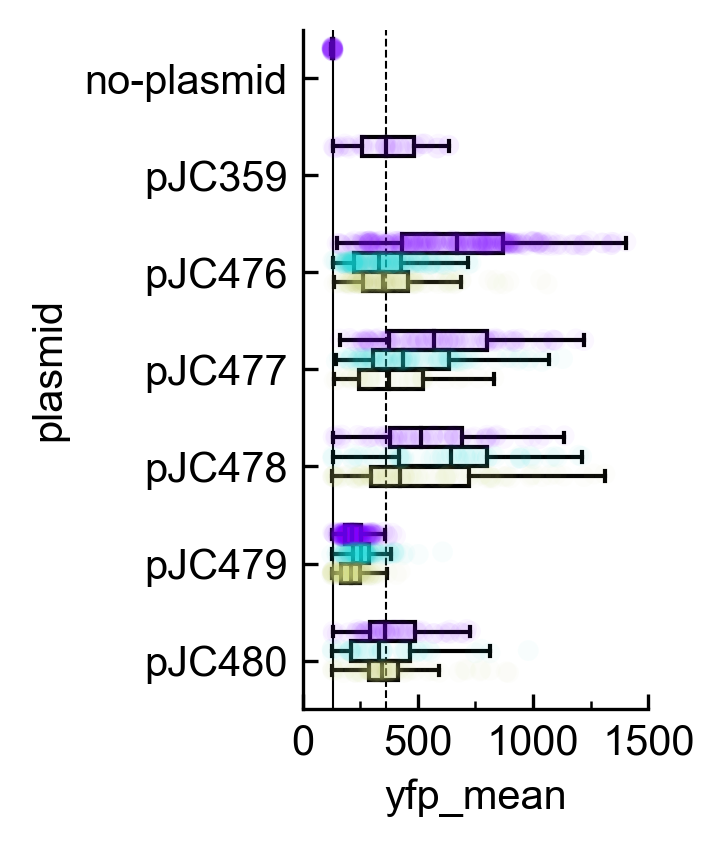

In [32]:
colvar = None
yvar = 'plasmid'
xvar = 'yfp_mean'
huevar = 'clone_number'
xorder = [
    'no-plasmid',
    'pJC359',
    'pJC476',
    'pJC477',
    'pJC478',
    'pJC479',
    'pJC480'
]
aggdex = [
    'plasmid',
    'clone_number',
    'sample_name'
]
cols = [col for col in alldf.columns if alldf[col].dtype!='O']
wanted_cols = aggdex + [col for col in cols if col not in aggdex]
# Will analyze means for each clone
table = alldf.loc[:, wanted_cols].pivot_table(index=aggdex, aggfunc='mean').reset_index()

grid = sns.FacetGrid(alldf)
grid.map(
    sns.stripplot,
    xvar,
    yvar,
    huevar,
    order=xorder,
    hue_order=[1, 2, 3, 4],
    dodge=True,
    palette='rainbow',
    alpha=0.03)
grid.map(
    sns.boxplot,
    xvar,
    yvar,
    huevar,
    order=xorder,
    hue_order=[1, 2, 3, 4],
    dodge=True,
    **plotting.transparent_boxes_prop_dict,
    showfliers=False)
grid.fig.set_dpi(300)
grid.fig.set_figwidth(2)
grid.fig.set_figheight(3)
grid.set(
    xlim=(0, 1500)
)
for ax in grid.axes[0]:
    ax.set_xticks(np.arange(0, 1501, 500))
    plotting.format_ticks(ax, add_minor_y=False)
    ax.axvline(alldf.loc[alldf.plasmid=='pJC359', 'yfp_mean'].median(), color='black', linestyle='--', linewidth=0.5),
    ax.axvline(alldf.loc[alldf.plasmid=='no-plasmid', 'yfp_mean'].median(), color='black', linestyle='-', linewidth=-0.5)
    pass

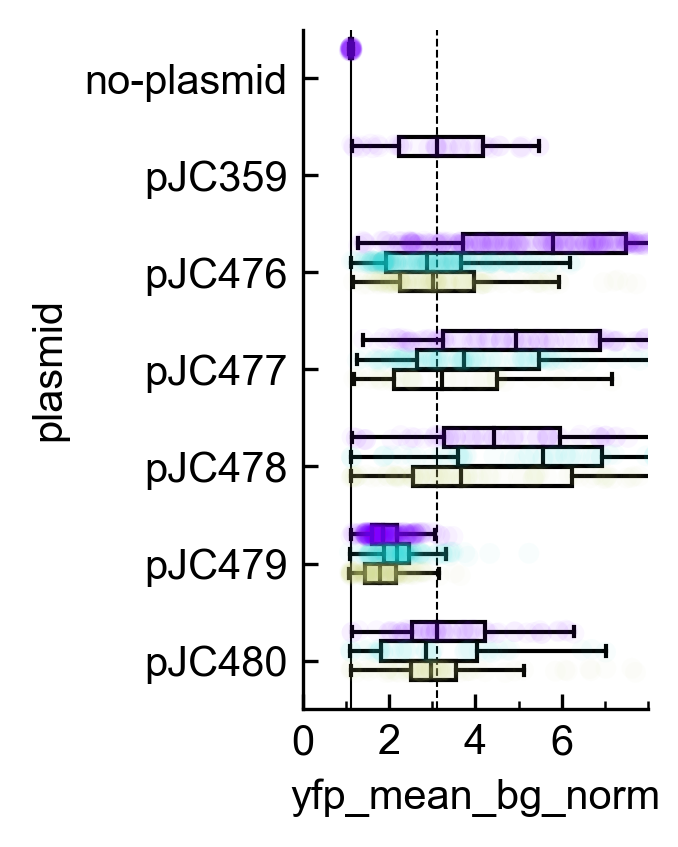

In [37]:
colvar = None
yvar = 'plasmid'
xvar = 'yfp_mean_bg_norm'
huevar = 'clone_number'
xorder = [
    'no-plasmid',
    'pJC359',
    'pJC476',
    'pJC477',
    'pJC478',
    'pJC479',
    'pJC480'
]
aggdex = [
    'plasmid',
    'clone_number',
    'sample_name'
]
cols = [col for col in alldf.columns if alldf[col].dtype!='O']
wanted_cols = aggdex + [col for col in cols if col not in aggdex]
# Will analyze means for each clone
table = alldf.loc[:, wanted_cols].pivot_table(index=aggdex, aggfunc='mean').reset_index()

grid = sns.FacetGrid(alldf)
grid.map(
    sns.stripplot,
    xvar,
    yvar,
    huevar,
    order=xorder,
    hue_order=[1, 2, 3],
    dodge=True,
    palette='rainbow',
    alpha=0.03)
grid.map(
    sns.boxplot,
    xvar,
    yvar,
    huevar,
    order=xorder,
    hue_order=[1, 2, 3, 4],
    dodge=True,
    **plotting.transparent_boxes_prop_dict,
    showfliers=False)
grid.fig.set_dpi(300)
grid.fig.set_figwidth(2)
grid.fig.set_figheight(3)
grid.set(
    xlim=(0, 8)
)
for ax in grid.axes[0]:
    ax.set_xticks(np.arange(0, 8, 2))
    plotting.format_ticks(ax, add_minor_y=False)
    ax.axvline(alldf.loc[alldf.plasmid=='pJC359', xvar].median(), color='black', linestyle='--', linewidth=0.5),
    ax.axvline(alldf.loc[alldf.plasmid=='no-plasmid', xvar].median(), color='black', linestyle='-', linewidth=-0.5)
    pass